# Exploring the ITCH model 

Here, I am going to do an analysis of the ITCH model (Ericson, et al., 2015). This will have a few stages. But first, we outline the ITCH model. The decision rule is:

$$
\begin{aligned}
x &= \beta_{I} \\
&+ \beta_{abs,reward} \cdot (RB-RA) \\
&+ \beta_{rel,reward} \cdot \frac{RB-RA}{(RA+RB)/2} \\
&+ \beta_{abs,delay} \cdot (DB-DA) \\
&+ \beta_{rel,delay} \cdot \frac{DB-DA}{(DA+DB)/2} \\
\end{aligned}
$$

where the stochastic choice rule is 

$$
P(choose B | data) = \Phi(x)
$$

where $\Phi()$ is the _standard_ cumulative normal distribution. In the original paper a cumulative logistic function was used.

$\beta_{I}$ is basically a bias parameter. The rest of the $\beta$ parameters decide the relative weights of either absolute vs relative comparisons of either the reward or delay attributes.

Ericson et al (2015) claim that these 'heuristic' (i.e. attribute-wise) models fit human data better than alternative-wise models. One reason this is a big deal is because the alternative-wise models (such as hyperbolic discounting) predict we are transitive in our preferences. Whereas attribute-wise models should allow intransitive preference orderings to be made. In terms of whether people have transitive vs instransitive preferences for inter-temporal choice, I would say the jury is still out - there is mixed evidence.

The core claim of Ericson et al (2015) about the superiority of the attribute wise models was critically undermined by sub-optimal methods of comparing model fits (see Wulff & van den Bos, 2017). Nevertheless, it remains vital for the community to thoroughly evaluate these heuristic, attribute-wise models.

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import seaborn as sns

import darc
from darc.delayed import models
from darc.designs import BayesianAdaptiveDesignGeneratorDARC, DesignSpaceBuilder
from dev.darc_parameter_recovery import simulated_experiment_trial_loop
from darc.data_plotting import data_plotter

import bad.triplot

# Can the ITCH model accurately account for hyperbolic discounting behaviour?

## Create a simulated participant who discounts according to the hyperbolic discounting behaviour
Create a true reponse model with given parameters

In [4]:
response_model = models.Hyperbolic(n_particles=10_000)
response_model.θ_true = pd.DataFrame.from_dict({'logk': [-4], 'α': [0.1]})

def hyperbolic_discount_func(delay, logk):
    '''hyperbolic discount function, used for plotting indifference curves'''
    k = np.exp(logk)
    return np.divide(1, (1 + k * delay))

For the sake of clarity, we will run a simulated experiment, fitting a hyperbolic model to this hyperbolic observer. This will allow us to see their behaviour well.

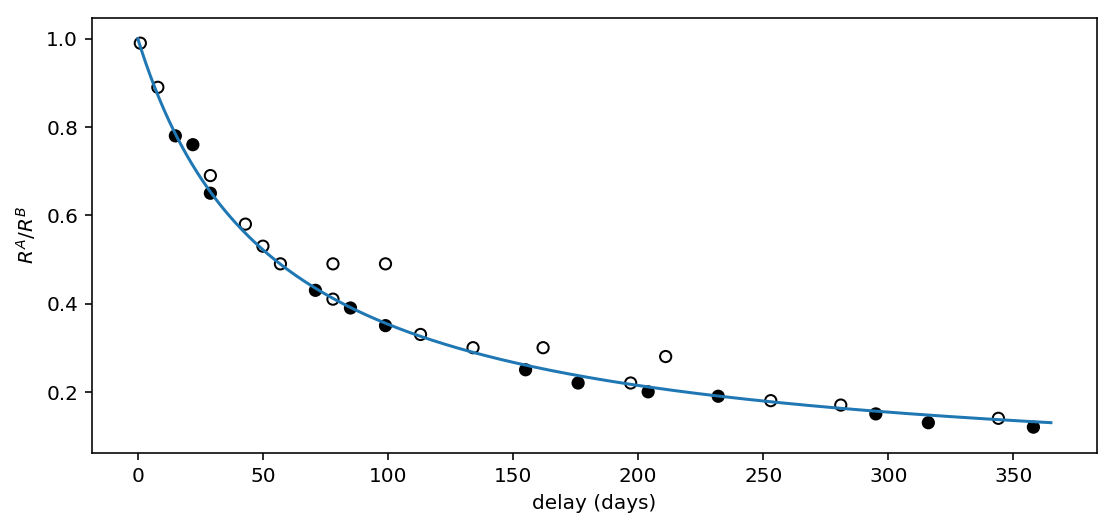

In [5]:
temp_model_to_fit = models.Hyperbolic(n_particles=10_000)

temp_D = DesignSpaceBuilder(RA=list(np.arange(5, 99+1, 1)), 
                            DB=list(np.arange(1, 365, 7))).build()
temp_design_thing = BayesianAdaptiveDesignGeneratorDARC(temp_D, 
                                                        max_trials=30)

temp_fitted_model, _ = simulated_experiment_trial_loop(temp_design_thing, 
                                                       temp_model_to_fit, 
                                                       response_model=response_model,
                                                       track_this_parameter=None)

data_plotter(temp_design_thing.get_df())

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, hyperbolic_discount_func(delays, response_model.θ_true['logk'].values))

## Use a heuristic design procedure to confirm ITCH can produce Hyperbolic discounting
To probe what is going on, I'm going to use a heuristic design procedure with the ITCH model.

In [6]:
from darc.delayed.designs import Frye, DuGreenMyerson2002

In [7]:
heuristic_design_thing = DuGreenMyerson2002(DB=np.arange(1, 365, 7*4))

heuristic_model_to_fit = models.ITCH(n_particles=10_000)

heuristic_fitted_model, _ = simulated_experiment_trial_loop(heuristic_design_thing, 
                                                  heuristic_model_to_fit, 
                                                  response_model=response_model,
                                                  track_this_parameter=None)

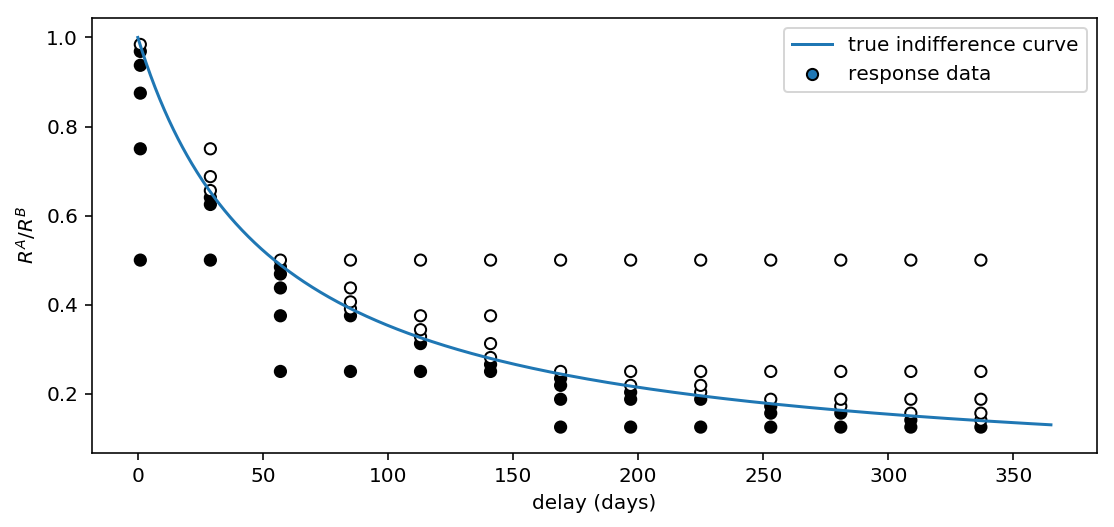

In [8]:
data_plotter(heuristic_design_thing.get_df())

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, 
         hyperbolic_discount_func(delays, response_model.θ_true['logk'].values),
         label='true indifference curve')
plt.legend();

The take home point here is that, yes, it does look like the ITCH model can produce inter-temporal discounting behaviour similar to a hyperbolic discounter.

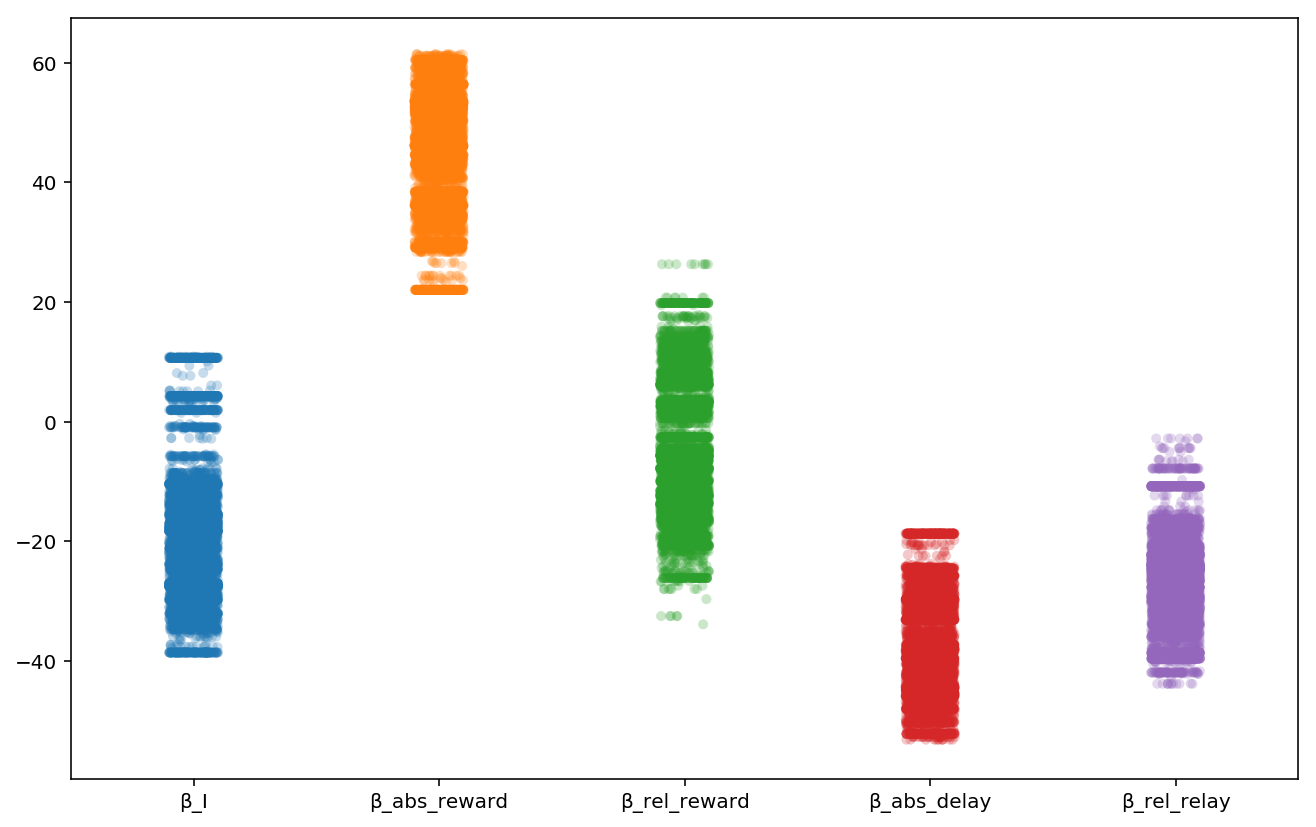

In [9]:
fig, ax = plt.subplots(figsize=(11, 7))

sns.stripplot(data=heuristic_fitted_model.θ, alpha=.25, jitter=True, ax=ax);

😨 WE ARE GETTING PATHOLOGY IN THE POSTERIOR

Let's grab the median parameter values into a vector for use later

In [10]:
median_params = tuple(np.median(heuristic_fitted_model.θ.values, axis=0))
median_params

(-19.621948004355,
 46.166505665812636,
 -5.650772705989447,
 -39.56549543343945,
 -25.584992087755662)

# Computing an indifference curve from the ITCH model analytically
It should be possible to rearrange the ITCH model equation by setting x=0, and solving for RA and plot RA/RB as a function of DA. This was we should be able to plot an indifference curve for our standard delay discounting design (no front end delay DA=0, fixed delayed reward RB=£100).

In [11]:
import sympy 

# pretty printing
sympy.init_printing()  

# define symbols
b0, b1, b2, b3, b4, RA, RB, DA, DB = sympy.symbols('b0 b1 b2 b3 b4 RA RB DA DB')

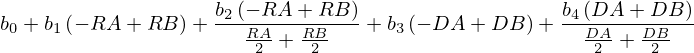

In [12]:
# define left and right hand sides of equation
LHS = 0  # setting x=0, which corresponds to indifference
RHS = b0 + b1*(RB-RA) + b2*((RB-RA)/((RB+RA)/2)) + b3*(DB-DA) + b4*((DB+DA)/((DA+DB)/2))

# visual check that we have specified the equation properly
RHS

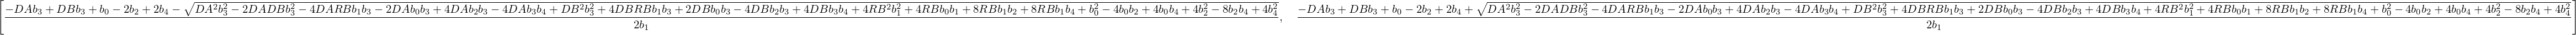

In [13]:
# solve for RA in general, just out of interest
solution = sympy.solve(LHS-RHS, RA)
solution

This is some hideous stuff!

Also note that there are TWO seprate solutions here

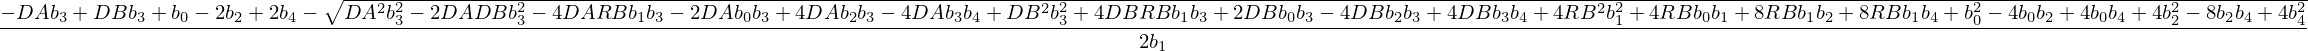

In [14]:
solution[0]

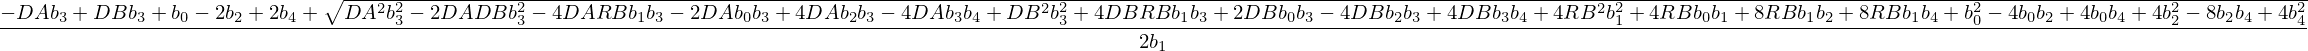

In [15]:
solution[1]

Now just solve for the specific case we are interested in when RB=100, DA=0

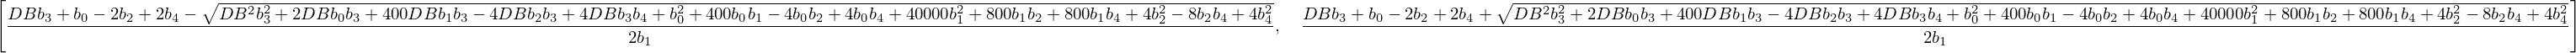

In [16]:
# solve when RB=100, DA=0
LHS = 0
RHS = b0 + b1*(100-RA) + b2*((100-RA)/((100+RA)/2)) + b3*(DB-0) + b4*((DB+0)/((0+DB)/2))
solution = sympy.solve(LHS-RHS, RA)
solution

Marignally less hideous, but still firmly in 🤮 territory.

Again, TWO solutions

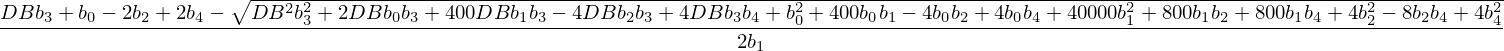

In [17]:
solution[0]

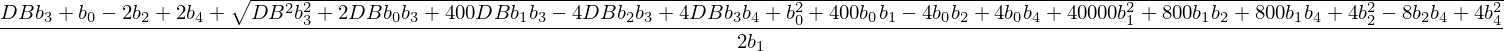

In [18]:
solution[1]

In [19]:
# get that as text so we can copy/paste below
print(solution[1])

(DB*b3 + b0 - 2*b2 + 2*b4 + sqrt(DB**2*b3**2 + 2*DB*b0*b3 + 400*DB*b1*b3 - 4*DB*b2*b3 + 4*DB*b3*b4 + b0**2 + 400*b0*b1 - 4*b0*b2 + 4*b0*b4 + 40000*b1**2 + 800*b1*b2 + 800*b1*b4 + 4*b2**2 - 8*b2*b4 + 4*b4**2))/(2*b1)


Let's try to use that to plot the analytical indifference curve

In [20]:
# define some parameter values
b0, b1, b2, b3, b4 = median_params

/Users/btvincent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


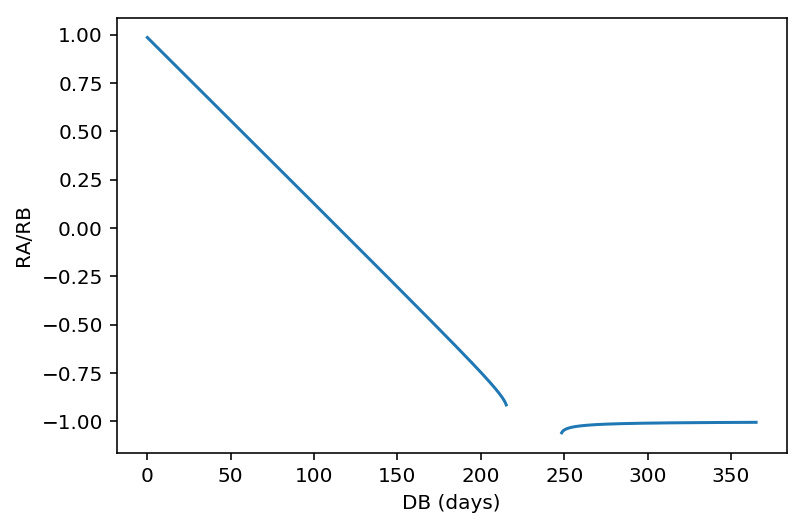

In [21]:
import matplotlib.pyplot as mpl

RB = 100
DB = np.linspace(0, 365, 1000)

def RA(DB, b0, b1, b2, b3, b4):
    '''RA as a function of DB and parameters'''
    return (DB*b3 + b0 - 2*b2 + 2*b4 + 
            np.sqrt(DB**2*b3**2 + 2*DB*b0*b3 + 400*DB*b1*b3 - 4*DB*b2*b3 
                    + 4*DB*b3*b4 + b0**2 + 400*b0*b1 - 4*b0*b2 + 4*b0*b4 
                    + 40000*b1**2 + 800*b1*b2 + 800*b1*b4 + 4*b2**2 
                    - 8*b2*b4 + 4*b4**2))/(2*b1)

RAoverRB = RA(DB, b0, b1, b2, b3, b4)/RB


plt.plot(DB, RAoverRB)
plt.xlabel("DB (days)")
plt.ylabel("RA/RB")
plt.show()

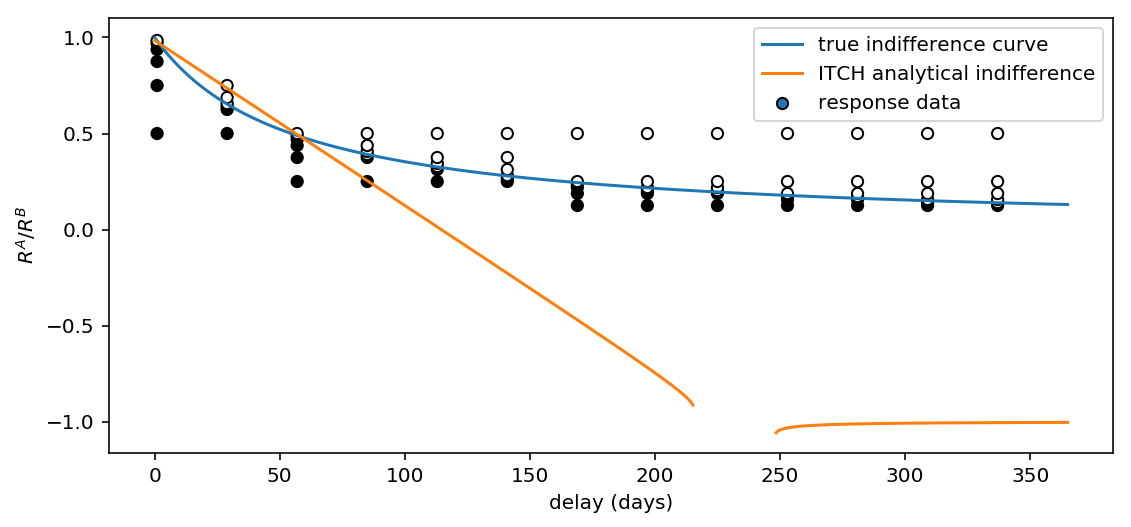

In [22]:
data_plotter(heuristic_design_thing.get_df())

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, 
         hyperbolic_discount_func(delays, response_model.θ_true['logk'].values),
         label='true indifference curve')
plt.plot(DB, RAoverRB, label='ITCH analytical indifference')
plt.legend();

Well, that's just plain wrong. Something is going wrong somewhere !?

# Use the DARC Toolbox to estimate parameters of an ITCH model
Again we assume an observer who actually discounts according to the hyperbolic discount function above. But we will use the DARC Toolbox to attemtp to select designs (near) optimally to estimate the parameters of the ITCH model.

Create an ITCH model which we will fit

In [23]:
model_to_fit = models.ITCH(n_particles=5_000)

D = DesignSpaceBuilder(RA=list(np.arange(5, 99+1, 1)), 
                       DB=list(np.arange(1, 365, 7))).build()
design_thing = BayesianAdaptiveDesignGeneratorDARC(D, max_trials=40)

fitted_model, _ = simulated_experiment_trial_loop(design_thing, 
                                                  model_to_fit, 
                                                  response_model=response_model,
                                                  track_this_parameter=None)

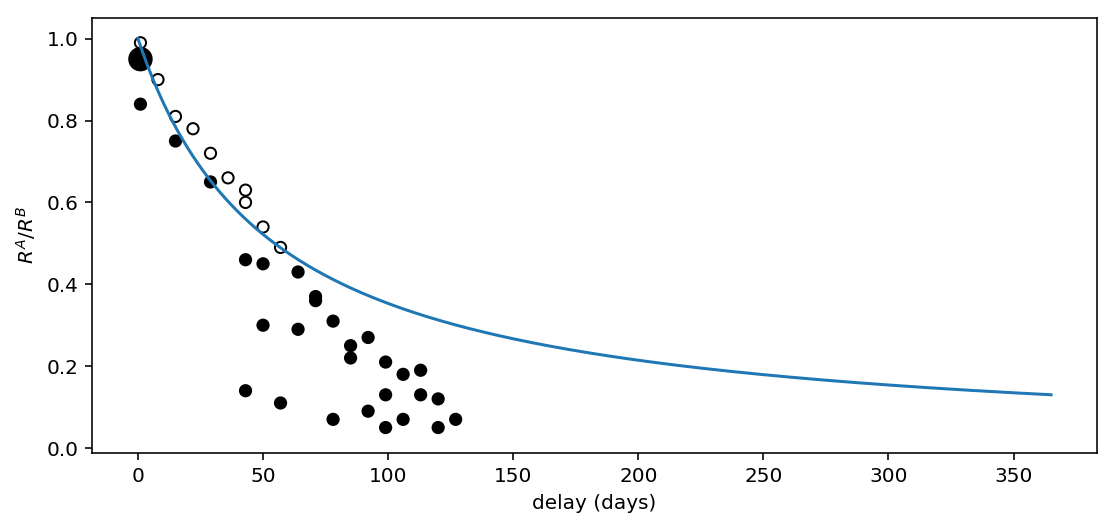

In [24]:
data_plotter(design_thing.get_df())

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, hyperbolic_discount_func(delays, response_model.θ_true['logk'].values));

So... we are getting an indication that the ITCH model _can_ produce behaviour consisten with a hyperbolic discounter. However, it seems that we are _not_ doing a good job of choosing designs in that they are not really around the indifference point.

Why?
- This might be because of a limitation of the ITCH model. Maybe the parameters are unidentifiable?
- It might also be due to our posterior beliefs becoming pathological and so we aren't able to do a good job of predicting which in turn means we'd not be able to choose good designs.
- Maybe it is because the priors we have set are so very vague?

Let's visualise the posterior beliefs, as we are likely still getting some pathology to the posterior.

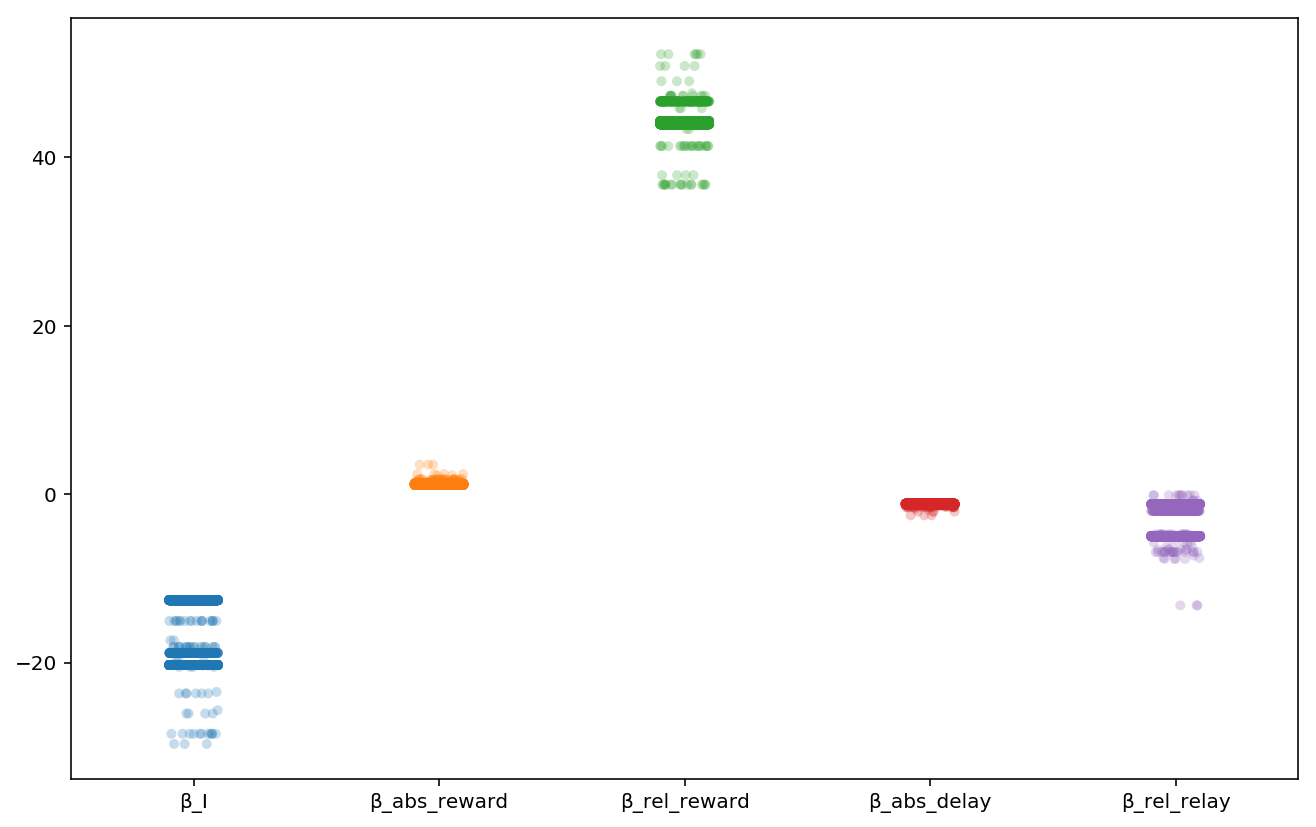

In [25]:
fig, ax = plt.subplots(figsize=(11, 7))

fitted_params = fitted_model.θ

sns.stripplot(data=fitted_params, alpha=.25, jitter=True, ax=ax);

😨 WE ARE GETTING SOME HORRIBLE PATHOLOGY IN THE PARTICLES... RATHER THAN BEING NICE SMOOTH DISTRIBUTIONS OVER PARAMETERS, THEY BECOME 'CLUMPED'

This implies that the badness of choosing designs for the ITCH parameter esimtation may well be due to pathologies in the posterior distribution. But I guess it does not rule out poor parameteristion of the ITCH model.

Also note that the estimated parameters using adpatively chosen designs is different from the estimated parameters estimated from the heuristic method we first did. This depends on the run that we did. But the core point is that we are getting pathology in the posterior distribution and we are _not_ getting stable parameter estimates.

# Is the ITCH model badly parameterised?

_These thoughts are currently incomplete._

The decision rule is:

$$
\begin{aligned}
x &= \beta_{I} \\
&+ \beta_{abs,reward} \cdot (RB-RA) \\
&+ \beta_{rel,reward} \cdot \frac{RB-RA}{(RA+RB)/2} \\
&+ \beta_{abs,delay} \cdot (DB-DA) \\
&+ \beta_{rel,delay} \cdot \frac{DB-DA}{(DA+DB)/2} \\
\end{aligned}
$$

If we pay particular attention to the units of the parameters:  
- $(RB-RA)$ is in units of £
- $\frac{RB-RA}{(RA+RB)/2}$ is in units of £
- $(DB-DA)$ is in units of days
- $\frac{DB-DA}{(DA+DB)/2}$ is in units of days

If you treat the $\beta$ coefficient as being unitless parameters, then this maybe gives rise to a problem. If we look at just $\beta_{abs,reward} \cdot (RB-RA) + \beta_{abs,delay} \cdot (DB-DA)$ then it means we are basically adding £ to days, which doesn't make sense.

_Is this a meaningful mathematical problem?_ If so, then the solution to this is to give the $\beta$ parameters some units so that they can convert all terms to a common set of units. It makes sense that this should be £. For example we could define $\beta_{abs,delay}$ and $\beta_{abs,delay}$ in units of £/day. This means

- $\beta_{abs,delay} \cdot (DB-DA)$ is now in units of £.
- $\beta_{rel,delay} \cdot \frac{DB-DA}{(DA+DB)/2}$ is also now in units of £.

This is nice as all the terms are in units of £. We can also interpret the decision variable $x$ as fundamantally based on rewards and emphasises the trade-offs in time delay and money.

Although it does raise the question of whether we need _all_ these parameters. _Maybe we need to try re-parameterising the model?_

# References

Ericson, K. M. M., White, J. M., Laibson, D., & Cohen, J. D. (2015). Money earlier or later? Simple heuristics explain intertemporal choices better than delay discounting does. Psychological Science, 26(6), 826–833. http://doi.org/10.1177/0956797615572232

Wulff, D. U., & van den Bos, W. (2017). Modeling Choices in Delay Discounting. Psychological Science, 1–5. http://doi.org/10.1177/0956797616664342